In [1]:
import pandas as pd
import json
import seaborn as sns
from matplotlib import pyplot as plt
import glob
import math
import numpy as np
from adjustText import adjust_text
from collections import defaultdict
import pickle as pkl

### Multiclass overall performance
Let's look at F1 in the multiclass classification task

In [2]:
sns.set_style('whitegrid')

In [3]:
def _plot_multiclass_metrics(data, metric, avg, idvar='model'):
    df_long = pd.melt(data, id_vars=idvar, value_vars=[f'train_{metric}_{avg}', f'test_{metric}_{avg}'])
    df_long['variable'] = df_long['variable'].replace({f'train_{metric}_{avg}': 'train', f'test_{metric}_{avg}': 'test'})
    fig, ax = plt.subplots(figsize=(10,7))
    sns.scatterplot(data=df_long, y=idvar, x='value', hue='variable', palette=['grey', 'darkorange'])
    plt.legend(title=None)
    sns.lineplot(data=df_long,  
                 x='value', 
                 y=idvar, 
                 hue=idvar,
                 legend=False, 
                 palette=['grey']*df_long[idvar].nunique(), 
                 alpha=.4)
    print('e')
    plt.xlim(0,.85)
    plt.xlabel(f'F1 {avg}')
    plt.ylabel('')
    plt.show()

Plot F1 macro performance

In [4]:
df = pd.DataFrame(json.load(open('../logs/baselines/beast_1fold_macro_5es.json')))
metrics = {}
for split in ['train', 'test']:
    pfiles = glob.glob(f'../logs/baselines/beast_1fold_macro_5es/pred_{split}*')
    for t in pfiles:
        preds = pkl.load(open(t, 'rb'))
        preds['dummy'] = 'TD'
        precisions = []
        recalls = []
        f1s = []
        for lab in ['TD', 'ASD', 'DEPR', 'SCHZ']:
            tp = preds[(preds['label']==lab) & (preds['dummy']==lab)].shape[0]
            fp = preds[(preds['label']!=lab) & (preds['dummy']==lab)].shape[0]
            fn = preds[(preds['label']==lab) & (preds['dummy']!=lab)].shape[0]
            precision = tp / (tp + fp) if tp + fp != 0 else 0
            recall = tp / (tp + fn)
            f1 = 2 * precision * recall / (precision + recall) if precision + recall != 0 else 0
            precisions.append(precision)
            recalls.append(recall)
            f1s.append(f1)
        avg_f1 = np.mean(f1s)
        avg_precision = np.mean(precisions)
        avg_recall = np.mean(recalls)
        metrics[f'{split}_f1_macro'] = avg_f1
        metrics[f'{split}_recall_macro'] = avg_recall
        metrics[f'{split}_precision_macro'] = avg_precision
        metrics['model'] = 'dummy'
df = pd.concat([df, pd.DataFrame([metrics])], ignore_index=True)

e


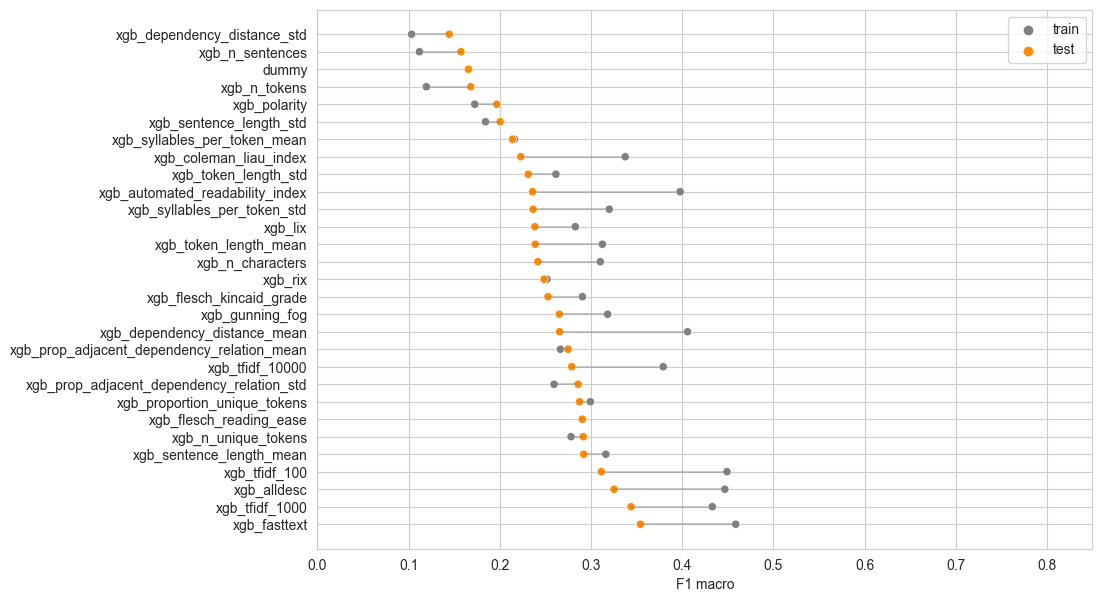

In [5]:
_plot_multiclass_metrics(df.sort_values(by='test_f1_macro'), 'f1', 'macro')

Let's visualize balance between precision and recall

In [6]:
def _precision_recall(data, avg):
    fig, ax = plt.subplots(figsize=(10,7))
    sns.scatterplot(data=data, x=f'test_precision_{avg}', y=f'test_recall_{avg}')
    sns.lineplot(x=[.0,.6], y=[.0,.6], color='grey', alpha=.7, linestyle='--')
    for i in range(data.shape[0]):
        plt.text(x=data[f'test_precision_{avg}'][i]+.002, 
                 y=data[f'test_recall_{avg}'][i]+.002, 
                 s=data['model'][i])
    plt.xlabel(f'test precision, {avg}')
    plt.ylabel(f'test recall, {avg}')
    plt.show()

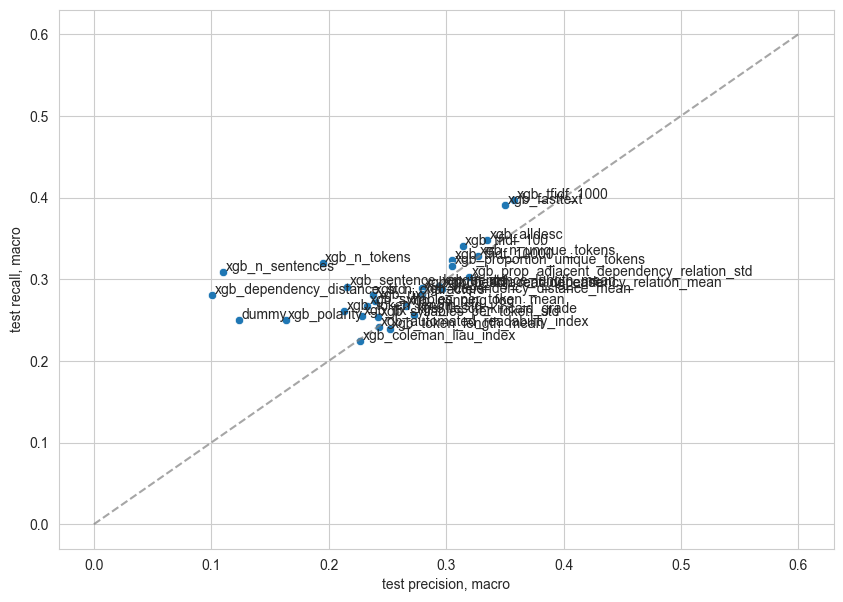

In [7]:
_precision_recall(df, 'macro')

### Now let's look at performance of the multiclass model for each class

(first just defining a couple of helper functions)

In [8]:
def _get_macro_metrics(f, metric='f1', binary=False, cat=None):
    ''' Args:
        f (str): filename
        metric (str): whether it is f1, or other
        binary (bool): whether it is a file from a binary classification model
        cat (str): if binary is True, which category it is (DEPR, ASD, or SCHZ)
    '''
    mdict = {'precision': 1, 'recall': 2, 'f1': 3}
    if binary is False:
        f1s = [float(s.split()[mdict[metric]]) for s in open(f).readlines()[12:16]]
        return dict(zip([f'TD_{metric}', 
                         f'DEPR_{metric}',
                         f'ASD_{metric}',
                         f'SCHZ_{metric}'], f1s))
    else:
        try:
            f1s = [float(s.split()[mdict[metric]]) for s in open(f).readlines()[11:12]]
        except:
            f1s = [float(s.split()[mdict[metric]]) for s in open(f).readlines()[10:11]]
        return dict(zip([cat+f'_{metric}'], f1s))

In [9]:
def _make_metric_df(fs, metric, binary, cat):
    lscores = []
    for f in fs:
        scores = _get_macro_metrics(f, metric, binary, cat)
        scores['model'] = '_'.join(f.split('/')[-1].split('.')[0].split('_')[1:])
        lscores.append(scores)
    out = pd.DataFrame(lscores)
    return out

In [10]:
def _swarmperf(data):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,4))
    for i, metric in enumerate(['f1', 'precision', 'recall']):
        df_long = pd.melt(data, id_vars='model', value_vars=[f'TD_{metric}',
                                                             f'ASD_{metric}',
                                                             f'SCHZ_{metric}',
                                                             f'DEPR_{metric}'])
        sns.swarmplot(data=df_long, x='variable', y='value', ax=ax[i])
        ax[i].set_xlabel('')
        ax[i].set_ylabel('')
        ax[i].set_ylim(-0.05,1)
        ax[i].set_title(metric)
    plt.show()

Ok, now let's look at F1 category by category, just starting from the overall distribution

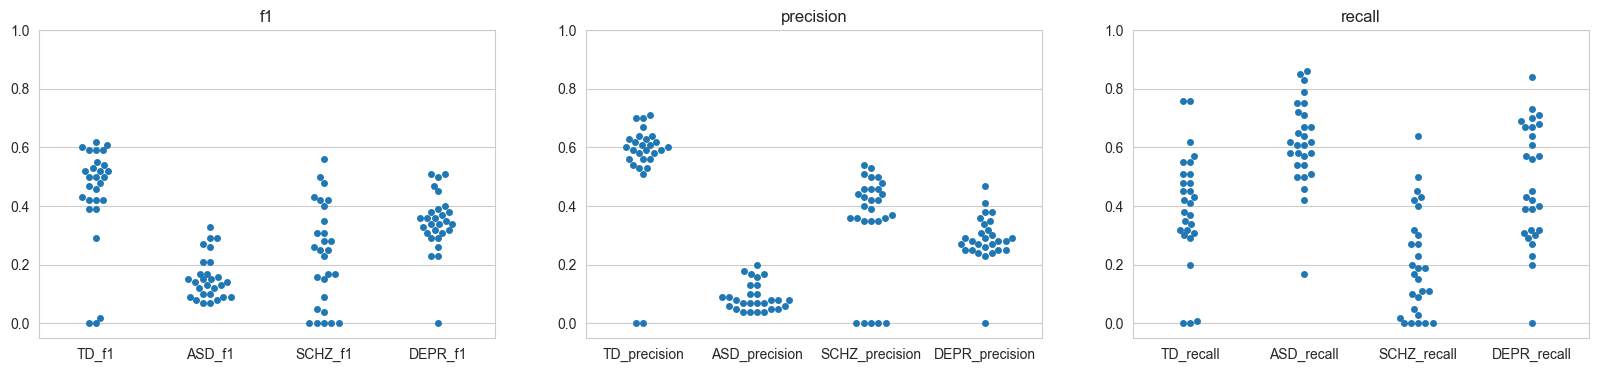

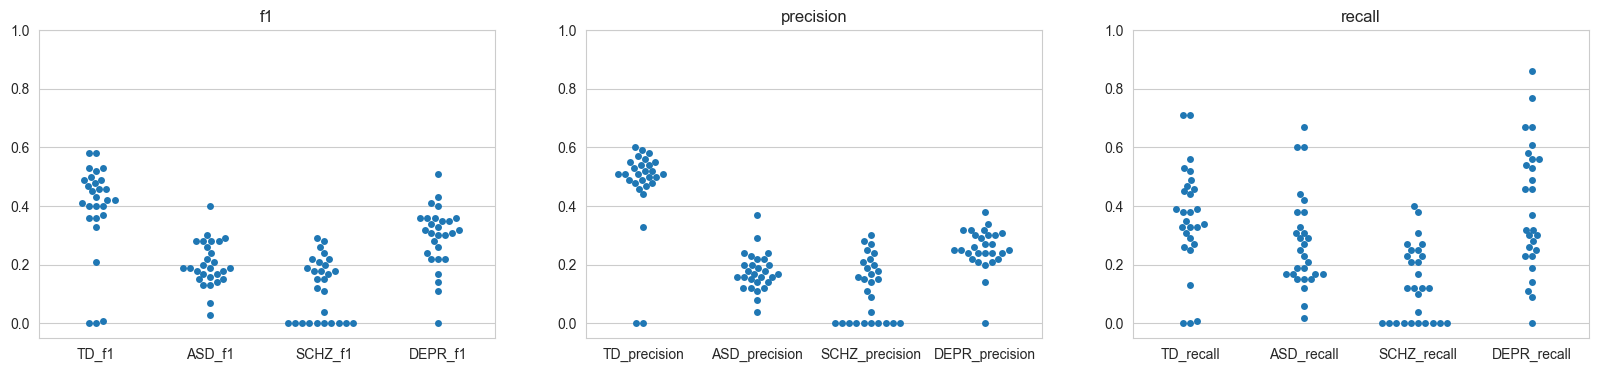

In [11]:
for t in ['train', 'test']:
    multi_files = glob.glob(f'../logs/baselines/beast_1fold_macro_5es/{t}*')
    multi = _make_metric_df(multi_files, 'f1', False, None)
    multi = multi.merge(_make_metric_df(multi_files, 'precision', False, None), on='model')
    multi = multi.merge(_make_metric_df(multi_files, 'recall', False, None), on='model')
    _swarmperf(multi)

This tells us that overall, baselines seem to be better to classify depression. <br> 
Now, it would be interesting to figure out whether model performance is balanced across the three categories, or whether some models do better on one vs. the other category. Let's find out.

In [12]:
best_asd = multi.sort_values(by='ASD_f1', ascending=False).head(n=10).iloc[:,1:5].model.unique().tolist()
best_schz = multi.sort_values(by='SCHZ_f1', ascending=False).head(n=10).iloc[:,1:5].model.unique().tolist()
best_depr = multi.sort_values(by='DEPR_f1', ascending=False).head(n=10).iloc[:,1:5].model.unique().tolist()
best_td = multi.sort_values(by='TD_f1', ascending=False).head(n=10).iloc[:,1:5].model.unique().tolist()
multi['is_best'] = multi['model'].isin(best_asd + best_schz + best_depr + best_td)
multi['is_best_asd'] = multi['model'].isin(best_asd)
multi['is_best_schz'] = multi['model'].isin(best_schz)
multi['is_best_depr'] = multi['model'].isin(best_depr)
multi['is_best_td'] = multi['model'].isin(best_td)

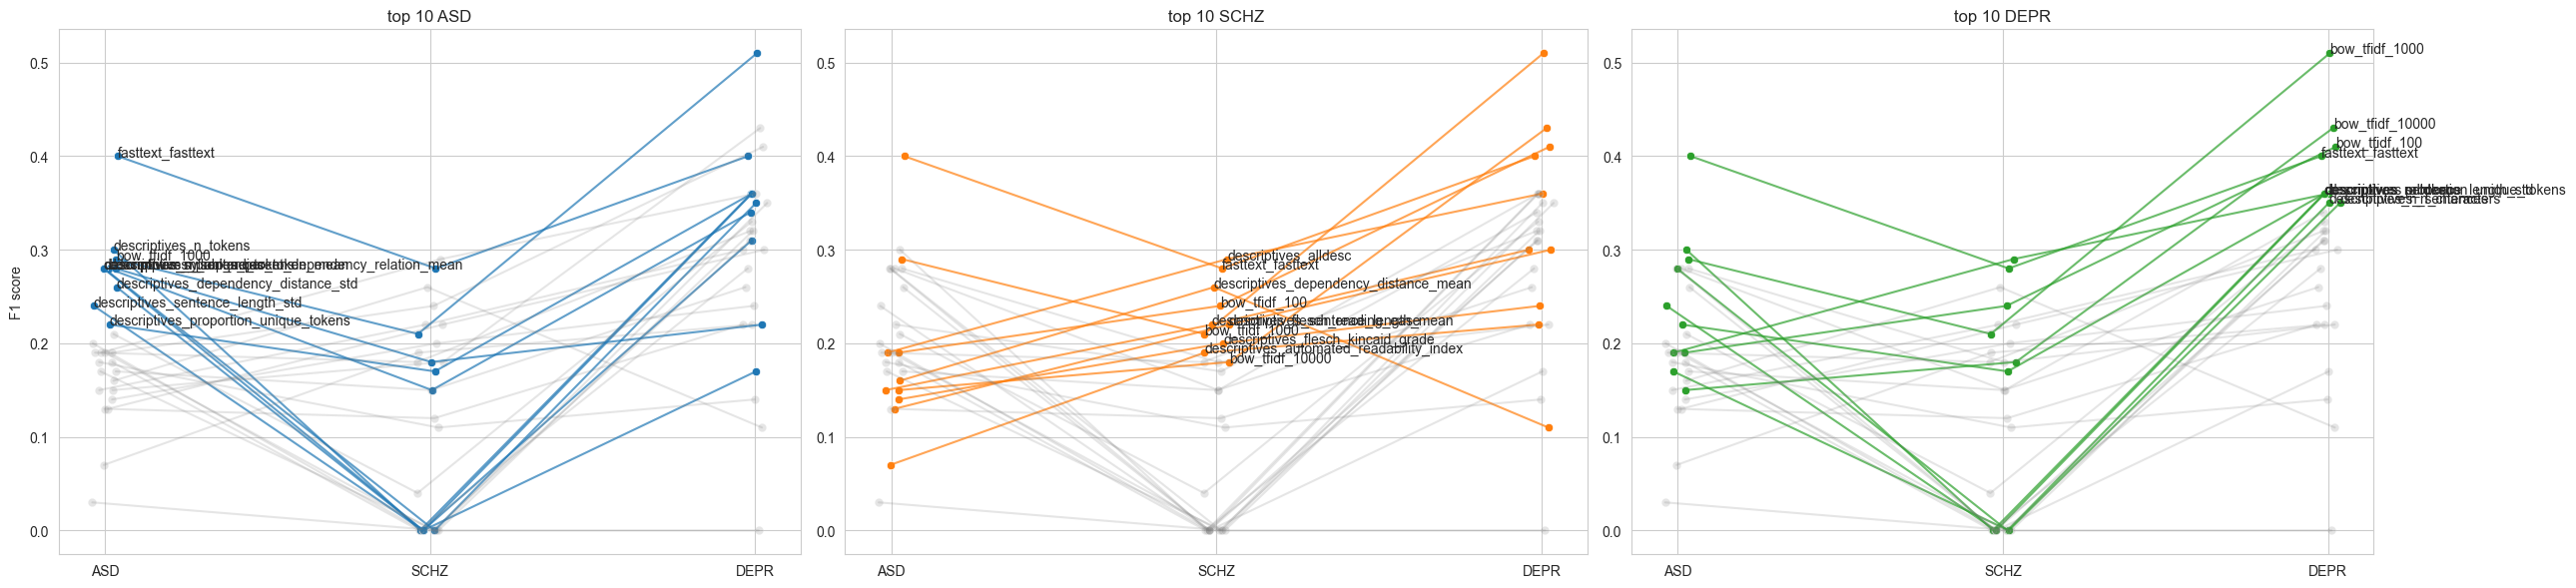

In [13]:
# Wide to long (needed for color coding)
df_long = pd.melt(multi, 
                  id_vars=['model', 
                           'is_best', 
                           'is_best_depr', 
                           'is_best_asd', 
                           'is_best_schz',
                           'is_best_td'], 
                  value_vars=[f'TD_f1', f'ASD_f1', f'SCHZ_f1', f'DEPR_f1'])
jitter = np.random.uniform(-.04,.04,df_long.shape[0])
df_long['variable_n'] = df_long['variable'].replace(dict(zip(['ASD_f1',
                                                              'SCHZ_f1',
                                                              'DEPR_f1',
                                                              'TD_f1'], 
                                                              range(4)))) + jitter

df_long = df_long[df_long['variable']!='TD_f1']
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(26,6))
for i, m in enumerate(['asd', 'schz', 'depr']):
    # Plot lines for best
    sns.lineplot(data=df_long[df_long[f'is_best_{m}']], 
                 x='variable_n', 
                 y='value', 
                 hue='model', 
                 alpha=.7, 
                 palette=[sns.color_palette()[i]]*10,
                 legend=False, 
                 ax=ax[i])
    # Plot lines for not best in grey
    sns.lineplot(data=df_long[~df_long[f'is_best_{m}']], 
                 x='variable_n', 
                 y='value', 
                 hue='model', 
                 alpha=.2, 
                 palette=['grey'] * int(df_long.model.nunique()-10),
                 legend=False, 
                 ax=ax[i])
    # Same deal with points
    sns.scatterplot(data=df_long[df_long[f'is_best_{m}']], 
                    x='variable_n', 
                    y='value', 
                    color=sns.color_palette()[i], 
                    ax=ax[i])
    sns.scatterplot(data=df_long[~df_long[f'is_best_{m}']], 
                    x='variable_n', 
                    y='value', 
                    color='grey', 
                    alpha=.2, 
                    ax=ax[i])
    ax[i].set_xticks(ticks=[0,1,2])
    ax[i].set_xticklabels(labels=['ASD', 'SCHZ', 'DEPR'])
    ax[i].set_xlabel('')
    # Add the annotations
    if i != 0:
        ax[i].set_ylabel('')
    else:
        ax[i].set_ylabel('F1 score')
    ax[i].set_title(f'top 10 {m.upper()}')
    for aix in range(df_long[df_long['variable_n'].round()==i].shape[0]):
        if df_long[df_long['variable_n'].round()==i][f'is_best_{m}'].tolist()[aix] == True:
            ax[i].text(x=df_long[df_long['variable_n'].round()==i]['variable_n'].tolist()[aix], 
                       y=df_long[df_long['variable_n'].round()==i]['value'].tolist()[aix],
                       s=df_long[df_long['variable_n'].round()==i]['model'].tolist()[aix])
plt.tight_layout()
plt.show()

### Compare performances for **multiclass** vs **binary** models

In [14]:
def _make_binary_df(model_id, split):
    asd_files = glob.glob(f'../logs/baselines/{model_id}_binary_ASD/{split}_*')
    depr_files = glob.glob(f'../logs/baselines/{model_id}_binary_DEPR/{split}_*')
    schz_files = glob.glob(f'../logs/baselines/{model_id}_binary_SCHZ/{split}_*')
    asd = _make_metric_df(asd_files, 'f1', True, 'ASD')
    depr = _make_metric_df(depr_files, 'f1', True, 'DEPR')
    schz = _make_metric_df(schz_files, 'f1', True, 'SCHZ')
    bins = schz.merge(asd.merge(depr, on='model', how='outer'), 
                      on='model', how='outer')
    return bins

In [15]:
bins = _make_binary_df('beast_1fold_5es', 'test')
bins['mtype'] = 'binary'
mpartial = multi.iloc[:,1:5]
mpartial['mtype'] = 'multiclass'
scores = pd.concat([bins, mpartial], ignore_index=True)
scores_wide = bins.merge(mpartial, on='model')

Before moving on to comparing multiclass and binary, let's take a look at training vs. test performance in the binary models.

In [16]:
bins_train = _make_binary_df('beast_1fold_5es', 'train')
bins_train['mtype'] = 'binary_train'
bins_all = pd.concat([bins, bins_train], ignore_index=True)
bins_val = _make_binary_df('beast_1fold_5es', 'val')
bins_val['mtype'] = 'binary_val'
bins_all = pd.concat([bins_all, bins_val], ignore_index=True)
bins_all = bins_all.replace({'binary': 'binary_test'})
bins_all['mtype'] = pd.Categorical(bins_all['mtype'],
                                   ordered=True,
                                   categories=['binary_train',
                                               'binary_val',
                                               'binary_test'])

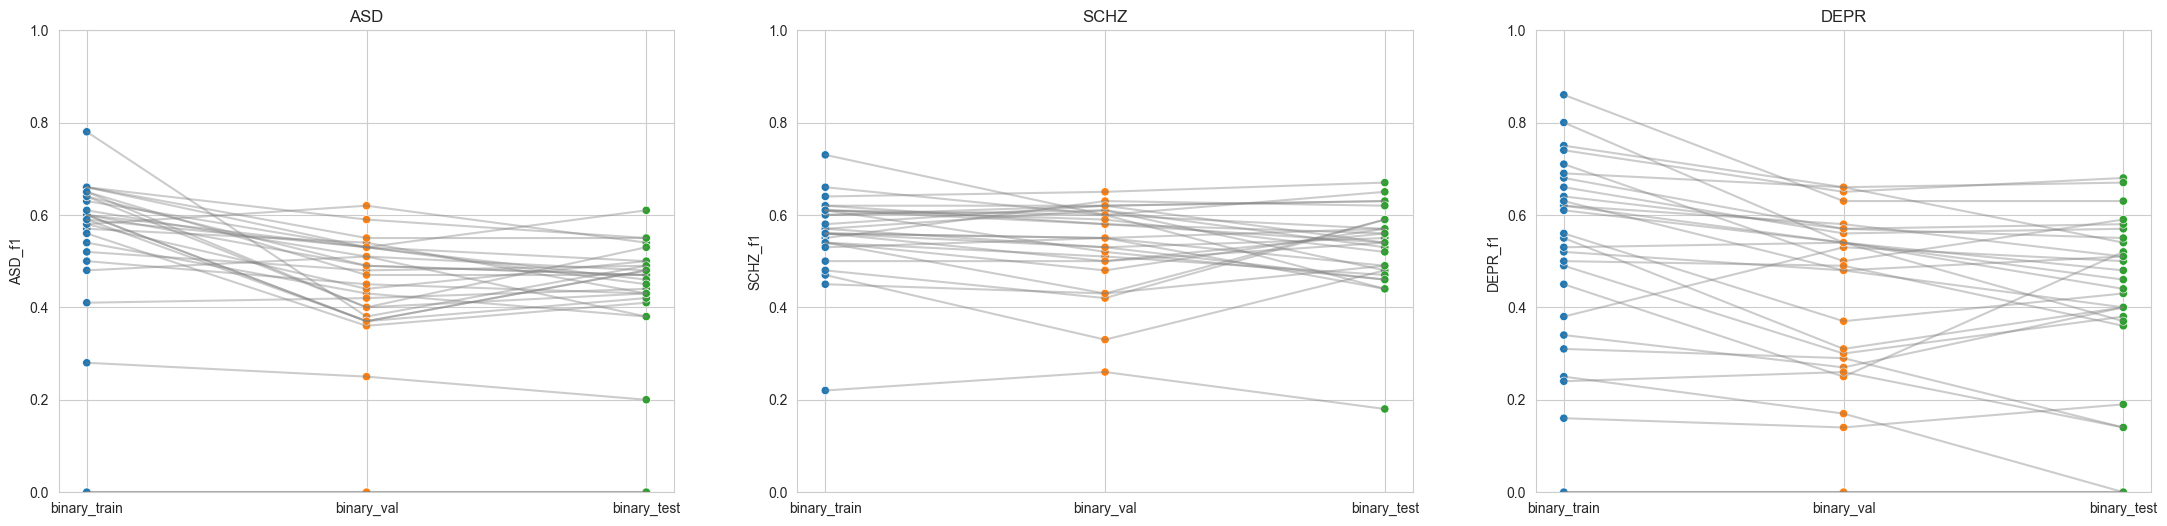

In [17]:
fig, ax = plt.subplots(figsize=(27,6), nrows=1, ncols=3)
for i,c in enumerate(['ASD', 'SCHZ', 'DEPR']):
    sns.lineplot(data=bins_all, 
                 x='mtype' ,y=f'{c}_f1', hue='model', 
                 legend=False, ax=ax[i], 
                 palette=['grey']*bins_all.model.nunique(),
                 alpha=.4)
    sns.scatterplot(data=bins_all, 
                    x='mtype' ,y=f'{c}_f1', hue='mtype', 
                    legend=False, ax=ax[i])
    ax[i].set_ylim(0,1)
    ax[i].set_title(c)
    ax[i].set_xlabel('')
plt.show()

Now on to comparing binary and multiclass, keeping in mind these patterns for train, validation, and test sets.

In [18]:
def _get_quantiles(cl, data):
    return data.sort_values(by=f'{cl}_f1', ascending=False)[f'{cl}_f1'].head(n=5).iloc[-1]

In [19]:
qdict = defaultdict(dict)
for cl in ['ASD', 'SCHZ', 'DEPR']:
    qdict[cl]['binary'] = _get_quantiles(cl, bins)
    qdict[cl]['multiclass'] = _get_quantiles(cl, multi)

In [20]:
def _compare_performance_plot(cl):
    fig, ax = plt.subplots(figsize=(10,7))
    sns.lineplot(x=[-0.1,1.1], y=[-0.1,1.1], color='grey', linestyle='--')
    ax.fill_between([qdict[cl]['binary']-.01, 1.1], 
                     -.1, 1.1, 
                     facecolor="none", 
                     color=sns.color_palette()[0], 
                     alpha=.4)
    ax.fill_between([-.1, 1.1],
                    qdict[cl]['multiclass']-.01, 1.1, 
                    facecolor="none", 
                    color='gold',  
                    alpha=.4)
    plt.axhline(y=qdict[cl]['multiclass']-.01, color='yellow', linestyle='--')
    plt.axvline(x=qdict[cl]['binary']-.01, color=sns.color_palette()[0], linestyle='--')
    plt.xlabel('binary F1')
    plt.ylabel('multiclass F1')
    sns.scatterplot(data=scores_wide, 
                    x=f'{cl}_f1_x', y=f'{cl}_f1_y')
    
    # Add labels
    texts = []
    for ix in range(len(scores_wide)):
        if scores_wide[f'{cl}_f1_x'][ix]>=qdict[cl]['binary'] or \
           scores_wide[f'{cl}_f1_y'][ix]>=qdict[cl]['multiclass']:
            if math.isfinite(scores_wide[f'{cl}_f1_x'][ix]):
                x = scores_wide[f'{cl}_f1_x'].iloc[ix]
                y = scores_wide[f'{cl}_f1_y'].iloc[ix]
                text = scores_wide['model'].iloc[ix]
                texts.append(ax.text(x, y, text))

    adjust_text(
        texts, 
        arrowprops=dict(
            arrowstyle="-", 
            color='black', 
            lw=1),
        ax=fig.axes[0]
    )

    plt.xlim(-0.09,1.1)
    plt.ylim(-0.09,1.1)
    plt.title(cl)
    plt.show()

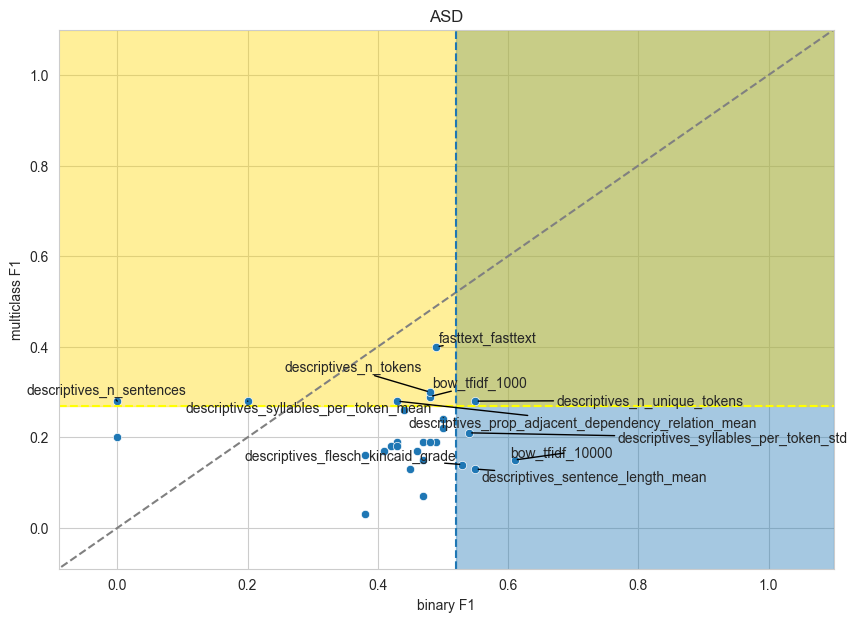

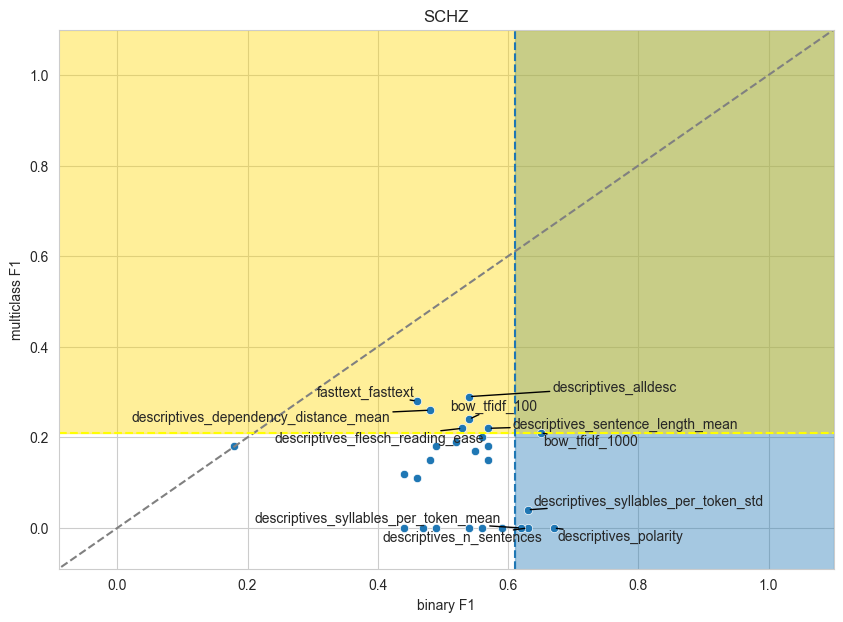

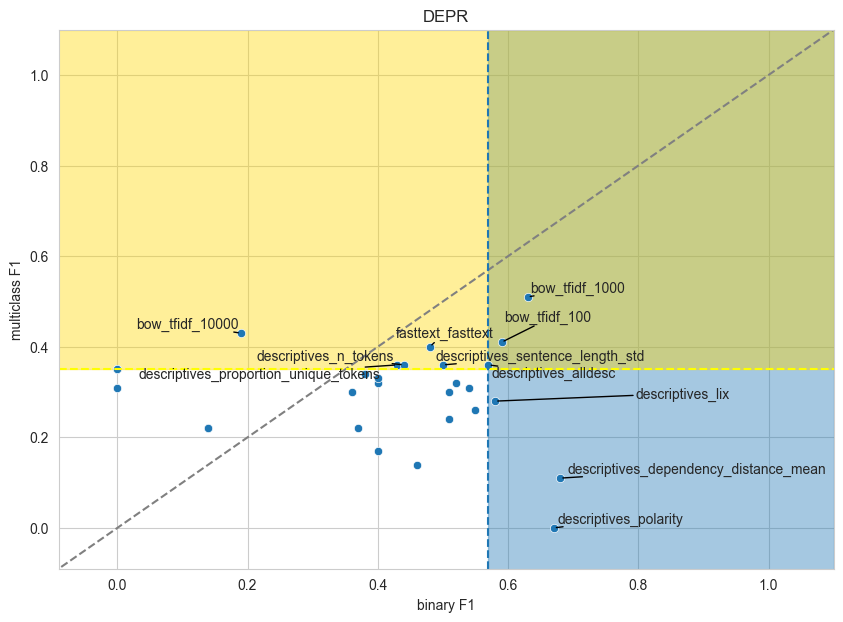

In [21]:
_compare_performance_plot('ASD')
_compare_performance_plot('SCHZ')
_compare_performance_plot('DEPR')

In [22]:
best_asd += bins.sort_values(by='ASD_f1', ascending=False).head(n=5).iloc[:,1:5].model.unique().tolist()
best_schz += bins.sort_values(by='SCHZ_f1', ascending=False).head(n=5).iloc[:,1:5].model.unique().tolist()
best_depr += bins.sort_values(by='DEPR_f1', ascending=False).head(n=5).iloc[:,1:5].model.unique().tolist()
scores['is_best'] = scores['model'].isin(best_asd + best_schz + best_depr)
scores['is_best_asd'] = scores['model'].isin(best_asd)
scores['is_best_schz'] = scores['model'].isin(best_schz)
scores['is_best_depr'] = scores['model'].isin(best_depr)

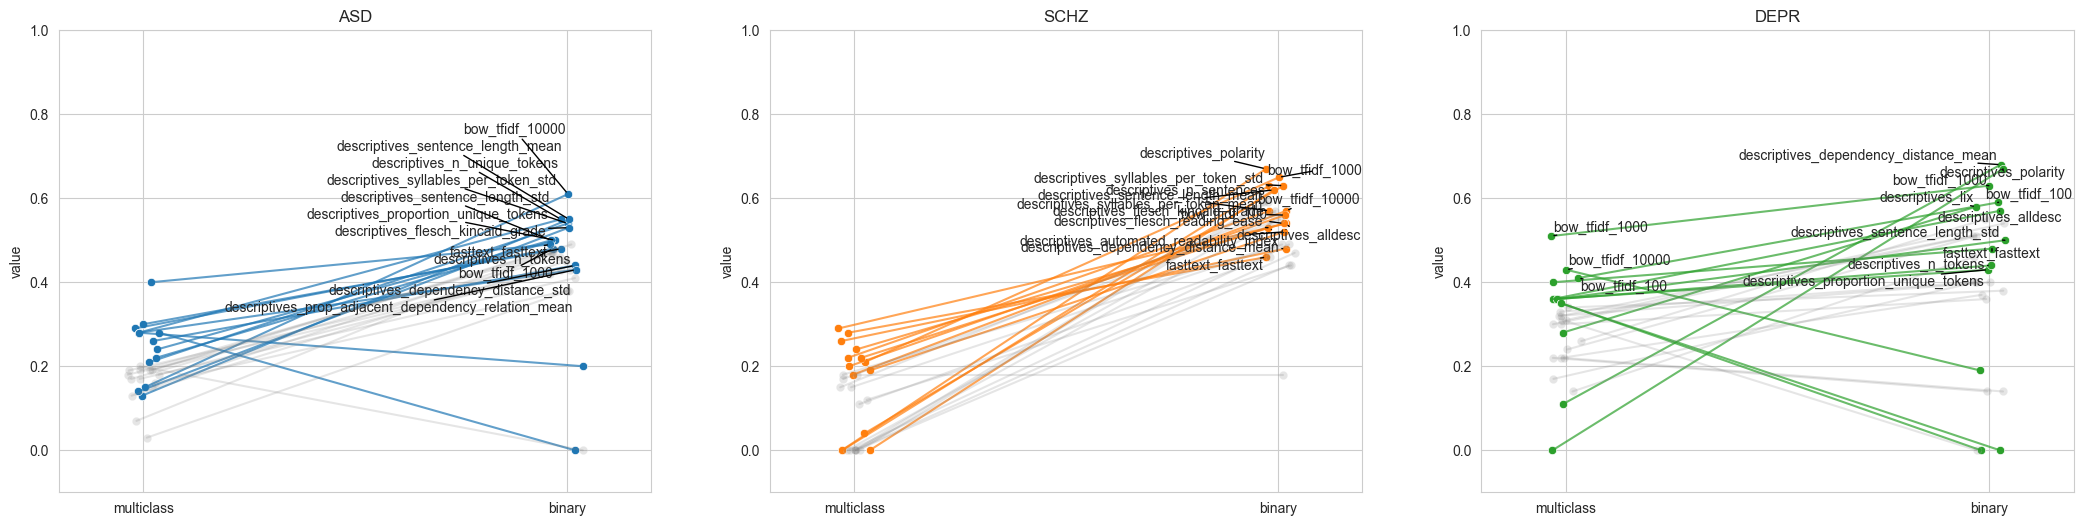

In [23]:
df_long = pd.melt(scores, 
                  id_vars=['model', 
                           'mtype',
                           'is_best', 
                           'is_best_depr', 
                           'is_best_asd', 
                           'is_best_schz'], 
                  value_vars=[f'ASD_f1', f'SCHZ_f1', f'DEPR_f1'])
jitter = np.random.uniform(-.04,.04,df_long.shape[0])
df_long['variable_n'] = df_long['mtype'].replace(dict(zip(['multiclass',
                                                           'binary'], 
                                                           range(0,2)))) + jitter
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(26,6))
for i, m in enumerate(['ASD_f1', 'SCHZ_f1', 'DEPR_f1']):
    # Plot lines for best
    dt = df_long[df_long['variable']==m]
    sns.lineplot(data=dt[dt[f'is_best_{m.split("_")[0].lower()}']], 
                 x='variable_n', 
                 y='value', 
                 hue='model', 
                 alpha=.7, 
                 palette=[sns.color_palette()[i]]*dt[dt[f'is_best_{m.split("_")[0].lower()}']].model.nunique(),
                 legend=False, 
                 ax=ax[i])
    # Plot lines for not best in grey
    sns.lineplot(data=dt[~dt[f'is_best_{m.split("_")[0].lower()}']], 
                 x='variable_n', 
                 y='value', 
                 hue='model', 
                 alpha=.2, 
                 palette=['grey']*dt[~dt[f'is_best_{m.split("_")[0].lower()}']].model.nunique(),
                 legend=False, 
                 ax=ax[i])
    # Same deal with points
    sns.scatterplot(data=dt[dt[f'is_best_{m.split("_")[0].lower()}']], 
                    x='variable_n', 
                    y='value', 
                    color=sns.color_palette()[i], 
                    ax=ax[i])
    sns.scatterplot(data=dt[~dt[f'is_best_{m.split("_")[0].lower()}']], 
                    x='variable_n', 
                    y='value', 
                    color='grey', 
                    alpha=.2, 
                    ax=ax[i])
    ax[i].set_xticks(ticks=[0,1])
    ax[i].set_xlim(-.2,1.2)
    ax[i].set_ylim(-.1, 1.)
    ax[i].set_xticklabels(labels=['multiclass', 'binary'])
    ax[i].set_xlabel('')
    ax[i].set_title(f'{m.split("_")[0]}')
    texts = []
    for aix in range(dt.shape[0]):
        if dt[f'is_best_{m.split("_")[0].lower()}'].tolist()[aix] == True:
            if dt['value'].tolist()[aix]>.4:
                texts.append(
                ax[i].text(x=dt['variable_n'].tolist()[aix], 
                           y=dt['value'].tolist()[aix],
                           s=dt['model'].tolist()[aix]))

    adjust_text(
        texts, 
        arrowprops=dict(
            arrowstyle="-", 
            color='black', 
            lw=1),
        only_move={'text':'y'},
        ax=ax[i])
plt.show()

### Correlation between descriptives

In [24]:
train_desc = pd.read_pickle('../data/vecs/train.csv')
val_desc = pd.read_pickle('../data/vecs/validation.csv')
test_desc = pd.read_pickle('../data/vecs/test.csv')
desc = pd.concat([train_desc, val_desc, test_desc], axis=0)

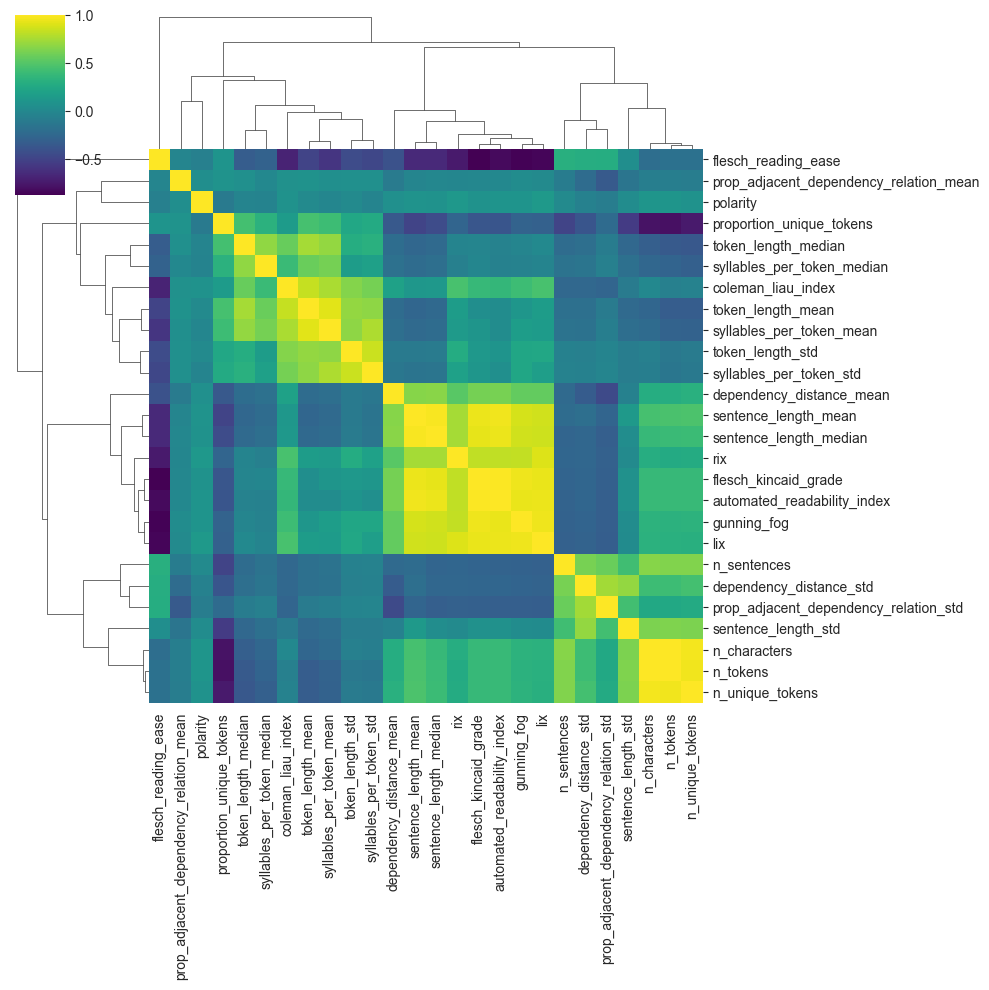

In [25]:
sns.clustermap(desc.iloc[:,1:27].corr(), cmap='viridis')

In [26]:
# print(' *** Dependency distance top values *** ')
#for k in desc.sort_values(by='dependency_distance_mean').tail(n=5).text.tolist():
#    print(k + '\n')
#print(' *** Dependency distance bottom values *** ')
#for k in desc.sort_values(by='dependency_distance_mean').head(n=5).text.tolist():
#    print(k + '\n')

## Pull examples

In [29]:
scores = pd.read_pickle('../logs/baselines/beast_1fold_macro_5es/pred_test_bow_tfidf_10000.pkl')
scores['DEPR_score'] = scores['scores'].apply(lambda x: x[1])
scores['SCHZ_score'] = scores['scores'].apply(lambda x: x[3])
scores['ASD_score'] = scores['scores'].apply(lambda x: x[2])

### Top and bottom predictions for DEPR
(select model by editing filename above)

In [30]:
desc[desc['ExampleID'].isin(scores.sort_values(by='DEPR_score').tail(n=5).trial_id.tolist())].text.tolist()

['Ikke som nogen speciel handling.',
 'Jeg tænker på nogen, der holder en svømmekonkurrence.',
 'Biler, der kører rundt, ?blandt andet?.',
 'Det er lidt ligesom det første klip.',
 'Det er bare, det er sådan noget livløs hoppen rundt.']

In [31]:
desc[desc['ExampleID'].isin(scores.sort_values(by='DEPR_score').head(n=5).trial_id.tolist())].text.tolist()

['øhm overordnet så så lignede det her meget at den røde trekant forsøgte at holde den blå inde i det der aflukke. øhm de øh de skubbede til hinanden der øhm den røde skubbede den blå derind og så øh forsøgte den blå og jeg tror faktisk at det var den blå der startede men øh . så øh gik den blå med spidsen først mod den røde hele tiden men øh men øh hver gang kunne ikke flytte den. den røde vendte sig om også med spidsen og gik spids mod spids og pressede den blå tilbage. pressede den blå op i et hjørne øh men så blev der en åbning og så farede den blå ud meget hurtigt. den røde gik ud drejede rundt der vendte sig om og kiggede kan man sige hvis det havde været mennesker og øhm så stod den stille.',
 'ja denne her gang der var der den der kasse inde i midten også . øhm og de igen så så for de rundt øhm men men selv om at bevægelserne umiddelbart så tilfældige ud så var de det ikke de gik øh samme retning de gik altid rundt og rundt. de kommer aldrig ind i den midterste kasse selv om de

### Top and bottom predictions for ASD

In [32]:
desc[desc['ExampleID'].isin(scores.sort_values(by='ASD_score').tail(n=5).trial_id.tolist())].text.tolist()

['øh ja men det var igen at de de skulle rundt om den her kasse. øhm men den her gang jeg tror i begyndelsen der øh der skiftede de lidt retning og det så det så endnu mere tilfældigt ud øhm altså hverken hvad kan man sige naturligt eller eller som om at der var et menneskeligt formål bag det. de drejede så jeg jeg synes så på et tidspunkt at øh holdt øje med den ene at den drejede øh den ene vej hele tiden men det gjorde den ikke øhm så så det var fuldstændigt tilfældigt og jeg tror endda at en af dem begyndte at skifte størrelse på et tidspunkt et øjeblik sådan lige puf . øhm så det kunne jeg hverken få hoved eller hale på.',
 'Ja det er jo noget med at så kommer den der store trekant ind først, og går rundt, og så kan vi så, og så følger den lille trekant med, jeg ved ikke det der blinken om det er fordi de leger gadedrengehop eller det er, hvad det er de har gang i. Men den der, den der store trekant den den den har nogen bevægelser der, så går de rundt, og så kigger den røde kant,

In [33]:
desc[desc['ExampleID'].isin(scores.sort_values(by='ASD_score').head(n=5).trial_id.tolist())].text.tolist()

['Jeg kom til at tænke på mus faktisk, at det var en musemor med sin unge, der ville have musen med ud, men det kunne ligeså godt være mennesker eller noget andet og det så er metaforisk - hvad hedder det, opbygning af det, det kunne have været alt.',
 'Nogle trekanter, som glider rundt, som var tæt på at mødes men gik forbi hinanden',
 'Den blå den var nede for neden og så kom den store røde og trynede den.',
 'Det kunne godt forstås som en en mor der gik hjemme og et barn der bankede på og så gemte sig for sjov. Den grinede og hvor moren forstod ikke, hvad det var. Og den bankede på igen og så blev de rigtig glade for at se hinanden.',
 'Man kunne godt forestille sig, at det var en moder og dets barn eller et dyr og en unge. Og den voksne ligesom prøvede at vise ungen, hvordan man kommer ud af noget der kunne se ud som et bur eller indhegning eller sådan noget. En form for voksenbarn træning.']

### Top and bottom predictions for SCHZ

In [34]:
desc[desc['ExampleID'].isin(scores.sort_values(by='SCHZ_score').tail(n=5).trial_id.tolist())].text.tolist()

['det som jeg så var at den det ligesom en scene hvor den røde trekant kommer ind først øhm og begynder at lave et eller andet. gå rundt. og så kom den blå og så den røde og bevægede sig hen til den gjorde det gjorde det samme, altså efterabede den hvorefter den røde vendte sig om og sagde at det synes den var irriterende og så gik den videre og den blå blev ved med at efterabe. og så skete der den samme situation en gang til, at den røde vendte sig om  og øh ja jeg forestiller mig at det var sådan lidt negativt, at den ville have at den skulle holde op, øhm og så vender den sig om og begynder at gå igen og den blå stadig efteraber og ender med at prikke til den røde hvorefter den røde vender sig om og bliver rigtig sur og skælder den ud, den blå.',
 'øhm nu bevægede de sig mere som en eller anden dans altså de de vendte sig i mod hinanden de snurrede rundt når den ene gik ind i hinanden så virkede det mere som om at at der blev skubbet meget blidt og der blev trukket. øhm nogen gange 

In [35]:
desc[desc['ExampleID'].isin(scores.sort_values(by='SCHZ_score').head(n=5).trial_id.tolist())].text.tolist()

['øhm ... jamen de er jo begge to inde i det der rum eller hvad det er men det virker som om endnu engang at den røde trekant helst bare vil være alene og endnu engang kommer det til en konflikt mellem de to trekanter og hvor at den røde så forsøger at lukke den blå trekant ude og den blå bliver ved med at konfrontere den røde trekant . ja jeg ved ikke lige hvad man mere',
 'Ja det er jo noget med at så kommer den der store trekant ind først, og går rundt, og så kan vi så, og så følger den lille trekant med, jeg ved ikke det der blinken om det er fordi de leger gadedrengehop eller det er, hvad det er de har gang i. Men den der, den der store trekant den den den har nogen bevægelser der, så går de rundt, og så kigger den røde kant, trekant tilbage, fordi den blå er fulgt med, den har en fornemmelse af det, men så lige når han kigger rundt, eller når den den røde trekant, den store røde trekant kigger rundt, så er det ligesom om den blå trekant den bare står sådan, øh ups der er ikke ske

### Aggregate scores

In [36]:
import json
labels = json.load(open('../data/labels.json'))
labels = dict(zip(labels.values(), labels.keys()))

In [37]:
models = ['_'.join(m.split('_')[1:]) for m in df['model'].unique().tolist()]

In [38]:
dfs = []
for m in models:
    metrics = {}
    metrics['model_name'] = m
    for split in ['train', 'test']:
        pfiles = glob.glob(f'../logs/baselines/beast_1fold_macro_5es/pred_{split}*{m}*')
        preds = pkl.load(open(pfiles[0], 'rb'))
        preds = preds.groupby(['id']).agg({'scores': lambda x: labels[np.argmax(np.mean(x))], # or majority vote?
                                           'label': 'first'}).reset_index()
        precisions = []
        recalls = []
        f1s = []
        for lab in ['TD', 'ASD', 'DEPR', 'SCHZ']:
            tp = preds[(preds['label']==lab) & (preds['scores']==lab)].shape[0]
            fp = preds[(preds['label']!=lab) & (preds['scores']==lab)].shape[0]
            fn = preds[(preds['label']==lab) & (preds['scores']!=lab)].shape[0]
            precision = tp / (tp + fp) if tp + fp != 0 else 0
            recall = tp / (tp + fn)
            f1 = 2 * precision * recall / (precision + recall) if precision + recall != 0 else 0
            precisions.append(precision)
            recalls.append(recall)
            f1s.append(f1)
        avg_f1 = np.nanmean(f1s)
        avg_precision = np.nanmean(precisions)
        avg_recall = np.nanmean(recalls)
        metrics[f'{split}_f1_macro'] = avg_f1
        metrics[f'{split}_recall_macro'] = avg_recall
        metrics[f'{split}_precision_macro'] = avg_precision
    dfs.append(metrics)
performances = pd.DataFrame(dfs)

e


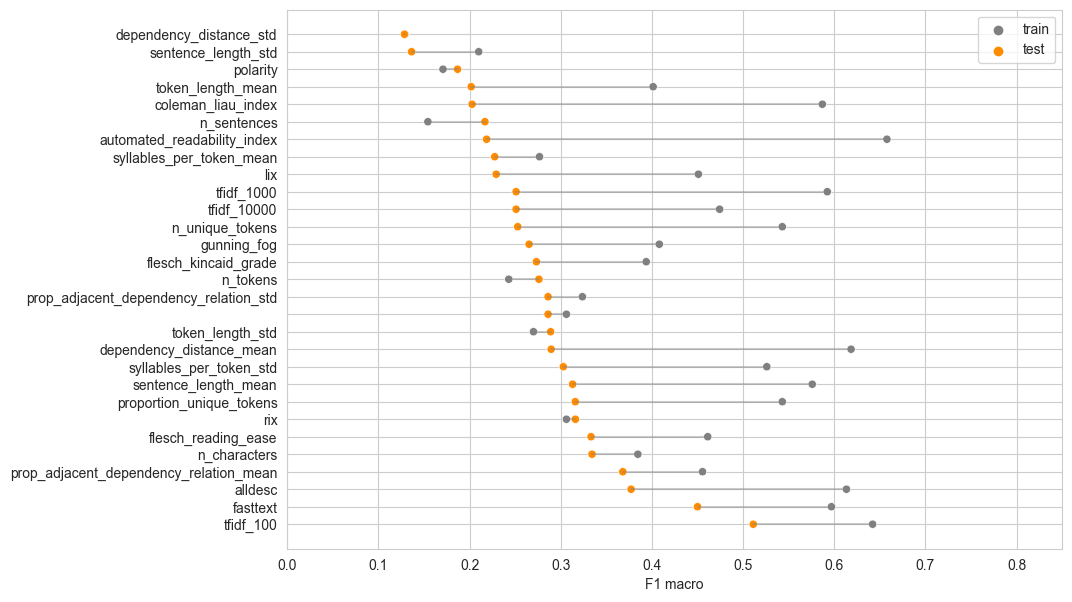

In [39]:
_plot_multiclass_metrics(performances.sort_values(by='test_f1_macro'), 'f1', 'macro', idvar='model_name')